Імпорт бібліотек

In [13]:
import pandas as pd
import numpy as np
from prophet import Prophet
from tqdm import tqdm
import matplotlib.pyplot as plt

Завантаження даних

In [14]:
df = pd.read_csv("forecast_revenue_dataset.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [15]:
test_df = df[(df['date'] >= '2024-01-01') & (df['date'] <= '2024-12-31')].copy()


In [16]:
train_df = df[df['date'] < '2024-01-01'].copy()

In [17]:
forecast_dates = pd.date_range(start="2024-01-01", end="2024-12-01", freq='MS')

Запуск Моделі

In [18]:
categories = train_df['category_id'].unique()
forecast_results = []

for cat_id in tqdm(categories, desc="Forecasting categories"):
    series = train_df[train_df['category_id'] == cat_id][['date', 'revenue']].dropna()
    series = series.rename(columns={'date': 'ds', 'revenue': 'y'})

    if len(series) < 12 or series['y'].nunique() <= 1:
        continue

    model = Prophet()
    try:
        model.fit(series)
        future = pd.DataFrame({'ds': forecast_dates})
        forecast = model.predict(future)[['ds', 'yhat']]
        forecast['category_id'] = cat_id
        forecast_results.append(forecast)
    except Exception as e:
        print(f"⚠️ Skipped category {cat_id}: {e}")
        continue

Forecasting categories:   0%|          | 0/5 [00:00<?, ?it/s]11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing
Forecasting categories:  20%|██        | 1/5 [00:00<00:00,  4.32it/s]11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing
Forecasting categories:  40%|████      | 2/5 [00:00<00:00,  4.25it/s]11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing
Forecasting categories:  60%|██████    | 3/5 [00:00<00:00,  4.39it/s]11:10:48 - cmdstanpy - INFO - Chain [1] start processing
11:10:48 - cmdstanpy - INFO - Chain [1] done processing
Forecasting categories:  80%|████████  | 4/5 [00:00<00:00,  3.95it/s]11:10:48 - cmdstanpy - INFO - Chain [1] start processing
11:10:48 - cmdstanpy - INFO - Chain [1] done processing
Forecasting categories: 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


Об'єднання Прогнозу з Фактом 

In [19]:
forecast_df = pd.concat(forecast_results, ignore_index=True)

actuals_df = test_df[['date', 'category_id', 'revenue']].rename(columns={'date': 'ds', 'revenue': 'actual'})

results = pd.merge(forecast_df, actuals_df, on=['category_id', 'ds'], how='inner')

Розрахунок метрик

In [20]:
results['abs_error'] = (results['actual'] - results['yhat']).abs()
results['pct_error'] = results['abs_error'] / results['actual'].replace(0, np.nan)
results['weighted_error'] = results['abs_error'] * results['actual']



In [25]:
# Drop rows with missing values
results_clean = results.dropna(subset=['actual', 'yhat'])

# Calculate absolute errors
results_clean['abs_error'] = (results_clean['actual'] - results_clean['yhat']).abs()
results_clean['pct_error'] = results_clean['abs_error'] / results_clean['actual'].replace(0, np.nan)
results_clean['weighted_error'] = results_clean['abs_error'] * results_clean['actual']

# MAE, MAPE
mae = results_clean['abs_error'].mean()
mape = results_clean['pct_error'].mean() * 100
wmape = (results_clean['weighted_error'].sum() / results_clean['actual'].sum()) * 100

# Put results into a clean DataFrame
metrics = pd.DataFrame([{
    'MAE': mae,
    'MAPE': mape,
    'WMAPE': wmape
}])


Відображення розрахованих метрик - Вибрати одну

In [26]:
print("📊 Forecast Accuracy (Revenue by Category, 2024):")
print(f"📌 MAE: {mae/1e6:.2f} million")
print(f"📌 MAPE: {mape:.2f}%")
print(f"📌 WMAPE: {wmape:.2f}%")

📊 Forecast Accuracy (Revenue by Category, 2024):
📌 MAE: 43.60 million
📌 MAPE: 23.80%
📌 WMAPE: 6445818678.23%


Візуалізація на графіку.

C:\Users\Admin\AppData\Local\Temp\ipykernel_17616\3660610073.py:15: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


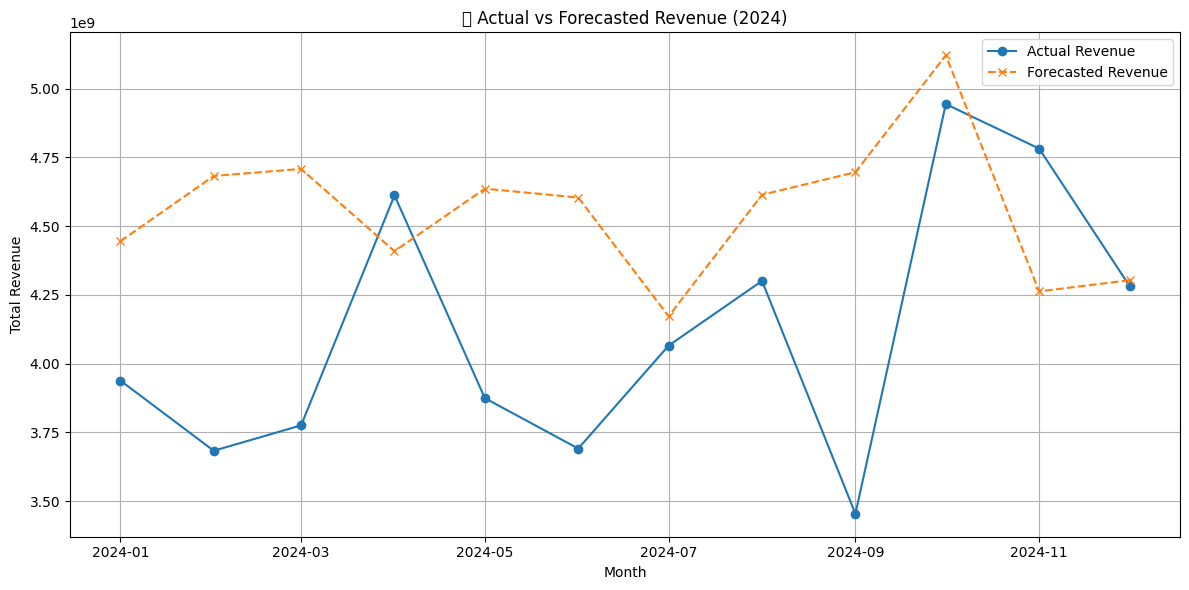

In [24]:
plot_df = results_clean.groupby('ds').agg({
    'actual': 'sum',
    'yhat': 'sum'
}).reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(plot_df['ds'], plot_df['actual'], marker='o', label='Actual Revenue')
plt.plot(plot_df['ds'], plot_df['yhat'], marker='x', linestyle='--', label='Forecasted Revenue')
plt.title("📉 Actual vs Forecasted Revenue (2024)")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()